# Data exploration and algorithms testing

## Libraries import

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

!pip install -q findspark
!pip install pyspark

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
sc = spark.sparkContext

In [3]:
import os
import pandas as pd
import zipfile
import re
import sys
import hashlib
import time
import shutil
import matplotlib.pyplot as plt

## Constants

In [40]:
FULL_DF_SIZE = 3000000 # just for information
DF_SIZE_EXPLORATION = 1000 # used in section data exploration... for tests on small sets
DF_SIZE_FINAL_EXECUTION = 100000 # used in section Final execution of the algorithm
SIMILARITY_THRESHOLD = 0.5 # Documents are considered similar is their silimarity is bigger, in the final execution

DATAFILE_PATTERN = '^([^,]+),(.*)'
AMAZON_SMALL_PATH = 'small_books.csv'
STOPWORDS_PATH = 'stopwords.txt'
BASE_DIR = os.path.join('')

# used for visualisations below
N_HASH = [10, 30, 80, 100, 200, 400, 1000]
DATA_SIZES = [500, 1000, 3000, 10000, 20000, 50000]

In [41]:
# TODO paste your credentials here
os.environ['KAGGLE_USERNAME'] = "TODO PASTE"
os.environ['KAGGLE_KEY'] = "TODO PASTE"
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


## Creating small csv

In [42]:
def create_small_csv(size=DF_SIZE_EXPLORATION):
    '''
    Generates csv file with subset of first N=*size* rows of the full dataset
    size: int, number of data rows in generated file
    returns: str, filename generated
    '''
    with zipfile.ZipFile("amazon-books-reviews.zip") as zip_folder:
          with zip_folder.open("Books_rating.csv") as file2:
              df_ratings = pd.read_csv(file2, nrows=size)

    df_ratings['Id'] = (df_ratings['Id'].apply(lambda x: str(x)) +
                          df_ratings['User_id'].apply(lambda x: str(x)) +
                          df_ratings['review/time'].apply(lambda x: str(x)))
    filename = f"small_books{size}.csv"
    df_ratings[['Id', 'review/text']].to_csv(filename, index=False)

    del df_ratings

    return filename

In [ ]:
# create_small_csv(44)

'small_books44.csv'

## Data preprocessing

Parsing and tokenization code was inspired by tutorial from the course page

### Data parsing

In [43]:
def parse_datafile_line(datafile_line):
    """
    Parse a line of the data file using the specified regular expression
    pattern
    datafile_line: str, input string that is a line from the data file
    Returns: str, a string parsed using the given regular expression and without
    the quote characters
    """
    if isinstance(datafile_line, bytes):
        datafile_line = datafile_line.decode("utf-8")
    match = re.search(DATAFILE_PATTERN, datafile_line)
    if match is None:
        return (datafile_line, -1)
    elif match.group(1) == 'Id':
        return (datafile_line, 0)
    else:
        review = f'{match.group(2)}'

        res = ''.join(i for i in match.group(1) if i!='"')
        return ((res, review), 1)

In [44]:
def load_data(path):
    """ Loads a data file
    path: str, input file name of the data file
    Returns: RDD of parsed valid lines
    """
    filename = os.path.join(BASE_DIR, path)
    raw = sc.textFile(filename, 4, 0).map(parse_datafile_line).cache()
    failed_n = (raw
              .filter(lambda s: s[1] == -1)
              .map(lambda s: s[0])
              .count())
    valid = (raw
             .filter(lambda s: s[1] == 1)
             .map(lambda s: s[0])
             .cache())

    print(f'{path} - Read {raw.count()} lines, successfully parsed {valid.count()} lines, failed to parse {failed_n} lines')

    return valid

Loading small dataset for simple tests through the notebook

In [45]:
amazon_small = load_data(create_small_csv(DF_SIZE_EXPLORATION))

small_books1000.csv - Read 1001 lines, successfully parsed 1000 lines, failed to parse 0 lines


In [46]:
for line in amazon_small.take(1):
    print(line)

('1882931173AVCGYZL8FQQTD940636800', '"This is only for Julie Strain fans. It\'s a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you\'re looking for heavy literary content, this isn\'t the place to find it -- there\'s only about 2 pages with text and everything else is photos.Bottom line: if you only want one book, the Six Foot One ... is probably a better choice, however, if you like Julie like I like Julie, you won\'t go wrong on this one either."')


### Tokenization

In [47]:
split_regex = r'\W+'

def simple_tokenize(string):
    """
    String tokenization
    string: str, input string
    Returns: a list of tokens
    """
    return [s for s in re.split(split_regex, string.lower()) if s != '']

In [48]:
stopfile = os.path.join(BASE_DIR, STOPWORDS_PATH)
stopwords = set(sc.textFile(stopfile).collect())

def tokenize(string):
    """
    String tokenization that excludes stopwords
    string: str, input string
    Returns: list of tokens without stopwords
    """
    return [s for s in re.split(split_regex, string.lower())
            if s != '' and not s in stopwords]

In [49]:
print(amazon_small.map(lambda s: (s[0], tokenize(s[1]))).take(1))

[('1882931173AVCGYZL8FQQTD940636800', ['julie', 'strain', 'fans', 'collection', 'photos', '80', 'pages', 'worth', 'nice', 'section', 'paintings', 'olivia', 're', 'looking', 'heavy', 'literary', 'content', 'isn', 'place', 'find', '2', 'pages', 'text', 'everything', 'else', 'photos', 'bottom', 'line', 'want', 'one', 'book', 'six', 'foot', 'one', 'probably', 'better', 'choice', 'however', 'like', 'julie', 'like', 'like', 'julie', 'won', 'go', 'wrong', 'one', 'either'])]


## Jaccard similarity

In [50]:
def jaccard_similarity(list1, list2):
    '''
    Caclulates Jaccard similarity of 2 lists
    returns: float, similarity rate
    '''
    set1, set2 = set(list1), set(list2)
    intersect = len(set1.intersection(set2))
    union = len(set1.union(set2))

    return intersect / union

In [51]:
jaccard_similarity(['I', 'am', 'batman', 'super', 'cool'], ['I', 'am', 'superman', 'cool'])

0.5

### Brute force approach

Calculating Jaccard similarity with every pair of lines

In [52]:
cross_small = (amazon_small
                .cartesian(amazon_small)
                .cache())
cross_small.take(1)

[(('1882931173AVCGYZL8FQQTD940636800',
   '"This is only for Julie Strain fans. It\'s a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you\'re looking for heavy literary content, this isn\'t the place to find it -- there\'s only about 2 pages with text and everything else is photos.Bottom line: if you only want one book, the Six Foot One ... is probably a better choice, however, if you like Julie like I like Julie, you won\'t go wrong on this one either."'),
  ('1882931173AVCGYZL8FQQTD940636800',
   '"This is only for Julie Strain fans. It\'s a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you\'re looking for heavy literary content, this isn\'t the place to find it -- there\'s only about 2 pages with text and everything else is photos.Bottom line: if you only want one book, the Six Foot One ... is probably a better choice, however, if you like Julie like I like Julie, you won\'t go wrong on

In [53]:
def compute_similarity(combined_line):
    """
    Computes similarity on a combination record
    combined_line: tuple, ((id1, value1), (id2, value2))
    pair: tuple, (id1, id2, jaccard similarity)
    """
    res = jaccard_similarity(tokenize(combined_line[0][1]),
                             tokenize(combined_line[1][1]))
    return (combined_line[0][0], combined_line[1][0], res)

In [54]:
similarities = (cross_small
                .map(lambda r: compute_similarity(r))
                .cache())
print(similarities.take(2))

[('1882931173AVCGYZL8FQQTD940636800', '1882931173AVCGYZL8FQQTD940636800', 1.0), ('1882931173AVCGYZL8FQQTD940636800', '0826414346A30TK6U7DNS82R1095724800', 0.01948051948051948)]


Take some highly similar values (but not identical)

In [55]:
some_similarities = similarities.filter(lambda p: p[2] < 1).takeOrdered(5, key=lambda s: -s[2])
actual_res = some_similarities[0][2]
some_similarities

[('0517150328AMKC1EJBUXDS2989107200',
  '0517150328AMKC1EJBUXDS2989107200',
  0.9904306220095693),
 ('0517150328AMKC1EJBUXDS2989107200',
  '0517150328AMKC1EJBUXDS2989107200',
  0.9904306220095693),
 ('0791054608A3778VKGYVZ76Q960163200', '0791054608nan960163200', 0.86),
 ('0791054608nan960163200', '0791054608A3778VKGYVZ76Q960163200', 0.86),
 ('B0000630MUnan1046649600', 'B0000630MUnan1046649600', 0.8484848484848485)]

### Minhash approach

In [56]:
def minhash_signature(data_str, num_hashes=80):
    '''
    Calculates minhash signature for row
    data_str: str, raw document
    num_hashes: number of hash functions

    returns: list, hash signature of document
    '''
    minhash = [float('inf')] * num_hashes

    for num in tokenize(data_str):
        for num_hash in range(num_hashes):
            hash_val = int(hashlib.sha1(str(num).encode() +
                                        str(num_hash).encode()).hexdigest(), 16) % 10**6
            minhash[num_hash] = min(minhash[num_hash], hash_val)

    return minhash

Displaying pair with the highest similarity from above and calculating Jaccard similarity based on signature

In [57]:
data = cross_small.filter(lambda p: p[0][0]==some_similarities[0][0]
                   and p[1][0]==some_similarities[0][1]).collect()[0]
minhash_res = jaccard_similarity(minhash_signature(data[0][1]), minhash_signature(data[1][1]))
data

(('0517150328AMKC1EJBUXDS2989107200',
  '"Kurt Seligmann, Surrealist artist par excellence, admitted &amp; unashamed bibliophile, has ravaged his occult library in a miraculous marriage giving birth to this classic historical account of Magic and Occultism; entirely written for the proverbial \'man about the street\', and a very cosmic avenue is here tread in an admireable chronological ordering of the various mystical houses. Addressing all the various occult(semantic definition of &quot;hidden &amp; rejected knowledge&quot;) routes via the shortcut of this Art Historian\'s scholarly mind, as a whole this work is one of the best and most easily approachable &quot;magic histories&quot; for those who have no previous knowledge concerning occultism except an undeniable interest and fascination with the mysterious and the spiritual.Kurt Seligmann is darkly fascinated and explores endlessly the multitude of historic beliefs concerning the study of the nature of evil... such as black magic,

In [58]:
print(f'Highly similar lines. Actual similarity: {round(actual_res, 3)}, Minhash similarity: {round(minhash_res, 3)}')

Highly similar lines. Actual similarity: 0.99, Minhash similarity: 1.0


#### Validation of parameter n for minhash

This section contains visualisations with different number of hash functions applied

##### Mean Absolute Errors (visualization)




Calculation of Mean Absolute Error between Jaccard similarity calculated explicitly vs via Minhash signatures

In [59]:
def calculate_and_plot_errors(cartesian_rdd=cross_small, n_hash=N_HASH):
    '''
    Calculates Jaccard similarity mean absolute error between minhash and actual value
    cartesian_rdd: rdd where each line is of format ((id1: str, line1: str), (id2: str, line2: str))
    n_hash: list, numbers of hash functions to try
    returns: list of MAE errors for each n of hashes
    '''
    res_errors = []

    for n in n_hash:
        similarities_compared = cartesian_rdd.map(lambda p:
                                                  (p[0][0], p[1][0],
                                                  jaccard_similarity(tokenize(p[0][1]), tokenize(p[1][1])),
                                                  jaccard_similarity(minhash_signature(p[0][1], n),
                                                                      minhash_signature(p[1][1], n)))
                                                  ).cache()
        res_temp = similarities_compared.map(lambda x: abs(x[2]-x[3])).mean()
        res_errors.append(res_temp)
        print('Finished for n = ', n)

    plt.figure(figsize=(8, 5))
    plt.plot(n_hash, res_errors, marker='o', linestyle='-', color='blue', label='Error vs. #Hashes')
    plt.title("Error vs. Number of Hash Functions")
    plt.xlabel("Number of Hash Functions")
    plt.ylabel("Error (MAE)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return res_errors

small_books50.csv - Read 51 lines, successfully parsed 50 lines, failed to parse 0 lines
Finished for n =  10
Finished for n =  30
Finished for n =  80
Finished for n =  100
Finished for n =  200
Finished for n =  400
Finished for n =  1000


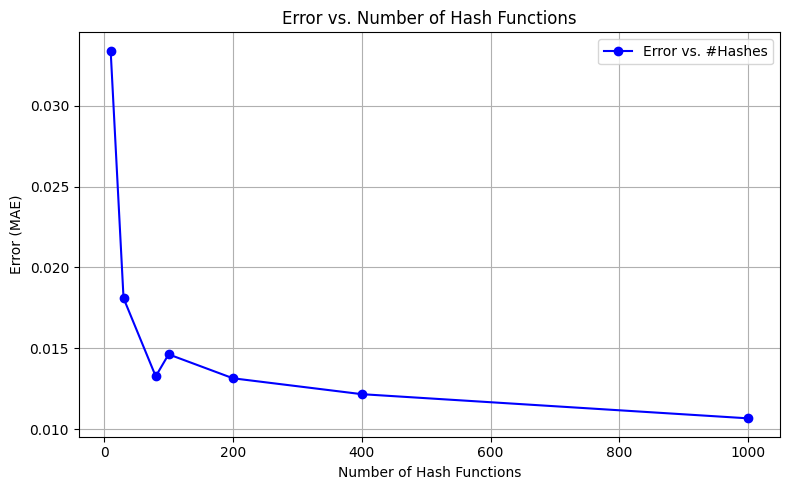

[0.03339768954005612,
 0.018102941265247384,
 0.013267128874629677,
 0.01462758104370832,
 0.013146894185612854,
 0.012165066907269574,
 0.010670893805624488]

In [ ]:
# May take some time

amazon_small_ = load_data(create_small_csv(50))
cross_small_ = (amazon_small_
                .cartesian(amazon_small_)
                .cache())

calculate_and_plot_errors(cross_small_)

##### Execution time (visualization)

In [60]:
def calculate_and_plot_exec_time(cross_small_bigger=cross_small, n_hash=N_HASH, n_repeats=1):
    '''
    Calculates and plots execution time depending on number of hash functions for minhash

    cross_small_bigger: rdd where each line is of format ((id1: str, line1: str), (id2: str, line2: str))
    n_hash: list, numbers of hash functions to try
    n_repeats: int, number of repeats of calculations to get more precise time

    returns: list with execution time for every n_hash
    '''
    res_time_minhash = []

    for n in n_hash:
        temp_lst_minhash = []
        for repeat in range(n_repeats):
            start = time.time()
            similarities_calculated = cross_small_bigger.map(lambda p:
                                                      (jaccard_similarity(minhash_signature(p[0][1], n),
                                                                          minhash_signature(p[1][1], n)))).collect()
            end = time.time()
            temp_lst_minhash.append(end-start)

        res_time_minhash.append(sum(temp_lst_minhash)/len(temp_lst_minhash))
        print('Finished for n = ', n)

    plt.figure(figsize=(8, 5))
    plt.plot(n_hash, res_time_minhash, marker='o', linestyle='-', color='blue', label='Minhash')
    plt.title("Time vs. Number of Hash Functions")
    plt.xlabel("Number of Hash Functions")
    plt.ylabel("Time")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return res_time_minhash

small_books50.csv - Read 51 lines, successfully parsed 50 lines, failed to parse 0 lines
Finished for n =  10
Finished for n =  30
Finished for n =  80
Finished for n =  100
Finished for n =  200
Finished for n =  400
Finished for n =  1000


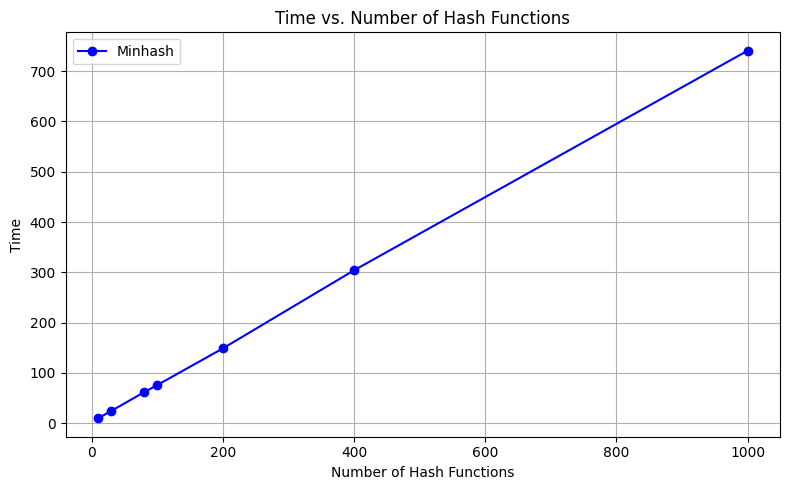

[9.471442699432373,
 24.22456645965576,
 61.36831593513489,
 75.61748576164246,
 148.47736597061157,
 303.8596806526184,
 740.7393310070038]

In [61]:
# Takes a bit of time, visualisations from the chart

amazon_small_ = load_data(create_small_csv(50))
cross_small_ = (amazon_small_
                .cartesian(amazon_small_)
                .cache())

calculate_and_plot_exec_time(cross_small_, n_hash=N_HASH)

Since execution time seems to be linear with respect to n_hash, and based on errors chart, N=80 is a good choice

#### Signature matrix calculation

In [62]:
signatures_calculated = amazon_small.map(lambda p: (p[0], minhash_signature(p[1], 80))).cache()
print(signatures_calculated.take(1))

[('1882931173AVCGYZL8FQQTD940636800', [10651, 44297, 2459, 54094, 37460, 114316, 24661, 41931, 8935, 8962, 20760, 106124, 21426, 3410, 4209, 36325, 17675, 4955, 14501, 31463, 54800, 2198, 14773, 15285, 5952, 32626, 52964, 21859, 13797, 61543, 2896, 79610, 13451, 14726, 11403, 4217, 40437, 4606, 20584, 79893, 1474, 10914, 17365, 10718, 20428, 9663, 2748, 25827, 79270, 17514, 17463, 7834, 34065, 35941, 5962, 13462, 7533, 6658, 21206, 8062, 14939, 2196, 22975, 22369, 36873, 39168, 4693, 8457, 21072, 34857, 25077, 29284, 10456, 2629, 36692, 723, 6560, 6085, 11658, 101639])]


## Locally-sensitive hashing

In [63]:
# num_hashes should be 80 as discussed, so b*r shoul == 80
b = 20 # bands
r = 4 # rows

print(f'Threshold is at s = (1/b)^(1/r) = {round((1/b)**(1/r), 3)}')

Threshold is at s = (1/b)^(1/r) = 0.473


In [64]:
def calculate_lsh(signature_row, n_bands, n_cols):
    '''
    Calculates hashes for sublists of input, lenght of each sublist is n_cols

    signature_row: tuple(string of id, list of minhash signatures)
    n_bands: number of bands row should be divided
    n_cols: number of values per band; n_cols * n_bands should be equal len(signature_row[1])

    returns: list of tuples where each tuple is (hash value, ID). Lenght of list is n_bands
    '''
    assert n_cols * n_bands == len(signature_row[1]), "n_cols * n_bands should be equal len(signature_row[1])"

    res = []
    pointer = 0
    while pointer < len(signature_row[1]):
        temp_list = signature_row[1][pointer: pointer+n_cols]
        hash_val = int(hashlib.sha1(str(temp_list).encode()).hexdigest(), 16) % 10**10
        res.append((hash_val, signature_row[0]))
        pointer += n_cols
    return res

In [65]:
lsh_matrix = signatures_calculated.flatMap(lambda x: (calculate_lsh(x, b, r))).cache()
print(lsh_matrix.take(1))

[(6856193494, '1882931173AVCGYZL8FQQTD940636800')]


### Finding candidate pairs

In [66]:
candidate_pairs = (lsh_matrix
                   .map(lambda x: (x[0], [x[1]]))
                   .reduceByKey(lambda a, b: a+b)
                   .filter(lambda r: len(set(r[1]))> 1))
print(candidate_pairs.take(2))

[(7219232040, ['0974289108A79QZ7YQFIXG61129075200', 'B0000630MUnan942537600']), (3709864872, ['B0007DVHU2A1RJD10TTI568L973987200', 'B0007DVHU2A1RJD10TTI568L1239321600'])]


### Similarity calculated among candidate pairs

In [67]:
def similarity_of_candidates(candidates_row, temp_dict_signatures):
    '''
    Calculates Jaccard similarity between candidate pairs
    candidates_row: tuple of format (hash_int, [id1, id2, id3, ...])
    temp_dict_signatures: dict, where key is id and value is hash signature

    returns list of triples (id1, id2, similarity_rate)
    '''
    res_lst = []
    # To avoid duplicated ids
    set_ids = list(set(candidates_row[1]))

    for i in range(len(set_ids)):
        for j in range(i+1, len(set_ids)):
            id1, id2 = set_ids[i], set_ids[j]
            signature1, signature2 = temp_dict_signatures[id1], temp_dict_signatures[id2]
            res = jaccard_similarity(signature1, signature2)
            res_lst.append((id1, id2, res))
    return res_lst

In [68]:
temp_dict_signatures = signatures_calculated.collectAsMap()

(candidate_pairs
 .flatMap(lambda x: similarity_of_candidates(x, temp_dict_signatures))
 .distinct()
 .takeOrdered(2, key=lambda s: -s[2]))

[('9687968478nan1050796800', '9687968478A2SZGIUKIIVDMS1128988800', 1.0),
 ('1555714137A1E8S4DQ0P4DVH949449600', '1555714137nan949449600', 1.0)]

# Final execution

## Execution on big dataset

Combining algorithms from above and running on the bigger dataset

In [24]:
amazon_bigger = load_data(create_small_csv(DF_SIZE_FINAL_EXECUTION))

small_books100000.csv - Read 100001 lines, successfully parsed 100000 lines, failed to parse 0 lines


In [25]:
signatures_calculated_bigger = (amazon_bigger
                                .map(lambda p: (p[0], minhash_signature(p[1], 80)))
                                .cache())
print(signatures_calculated_bigger.take(1))

[('1882931173AVCGYZL8FQQTD940636800', [10651, 44297, 2459, 54094, 37460, 114316, 24661, 41931, 8935, 8962, 20760, 106124, 21426, 3410, 4209, 36325, 17675, 4955, 14501, 31463, 54800, 2198, 14773, 15285, 5952, 32626, 52964, 21859, 13797, 61543, 2896, 79610, 13451, 14726, 11403, 4217, 40437, 4606, 20584, 79893, 1474, 10914, 17365, 10718, 20428, 9663, 2748, 25827, 79270, 17514, 17463, 7834, 34065, 35941, 5962, 13462, 7533, 6658, 21206, 8062, 14939, 2196, 22975, 22369, 36873, 39168, 4693, 8457, 21072, 34857, 25077, 29284, 10456, 2629, 36692, 723, 6560, 6085, 11658, 101639])]


In [26]:
lsh_matrix_bigger = (signatures_calculated_bigger
                     .flatMap(lambda x: (calculate_lsh(x, b, r)))
                     .cache())
print(lsh_matrix_bigger.take(1))

[(6856193494, '1882931173AVCGYZL8FQQTD940636800')]


In [27]:
candidate_pairs_bigger = (lsh_matrix_bigger
                          .map(lambda x: (x[0], [x[1]]))
                          .reduceByKey(lambda a, b: a+b)
                          .filter(lambda r: len(set(r[1]))> 1))

print(candidate_pairs_bigger.take(1))

[(416074360, ['1882931173AVCGYZL8FQQTD940636800', 'B000KIT9U4A2EQC9MEICEEK11062633600'])]


In [28]:
temp_dict_signatures = signatures_calculated_bigger.collectAsMap()
amazon_bigger_dict = amazon_bigger.collectAsMap()

In [29]:
similarity_calculated_bigger = (candidate_pairs_bigger
                                .flatMap(lambda x: similarity_of_candidates(x, temp_dict_signatures))
                                .distinct())

print(similarity_calculated_bigger.take(1))

[('0793514789AATLRZU07XNK01273622400', 'B0007F2VL4nan924825600', 0.03225806451612903)]


Choosing as similar lines with Jaccard similarity bigger than threshold

In [30]:
merged_rdd = (similarity_calculated_bigger
              .filter(lambda x: x[2] > SIMILARITY_THRESHOLD)
              .map(lambda x: (x[0], amazon_bigger_dict[x[0]],
                              x[1], amazon_bigger_dict[x[1]],
                              x[2])))

print("Random line: \n", "\n".join(str(i) for i in merged_rdd.take(1)[0]))
print('\nRandom line with similarity between 0.5 and 0.9: \n',
      "\n".join(str(i) for i in merged_rdd.filter(lambda x: x[4] > 0.5 and
                                                  x[4] < 0.9).take(1)[0]))

Random line: 
 B0006DG9OMA3RXB48GSN1CES1349740800
This is a wonderful book to read. It was one of the first classics I downloaded to my Kindle & was not disappointed. Would highly recommend it!
0333168968A3RXB48GSN1CES1349740800
This is a wonderful book to read. It was one of the first classics I downloaded to my Kindle & was not disappointed. Would highly recommend it!
1.0

Random line with similarity between 0.5 and 0.9: 
 0786197005A20EEWWSFMZ1PN1248480000
"""I have never told this story nor shall mortal man see this manuscript until I have passed over for eternity. I know that the average human mind will not believe what it can not grasp......""Written in 1912 this book is well written for its time and has intrigued countless generations of readers. I get the feeling that this story is being told over a campfire.Captain Carter is telling the story form memory as an old man of his adventures here on earth and on the planet of Barsoom (Mars). There are encounters with many strain cre

### Saving of results

Generating .csv with found similar pairs and their Jaccard similarities

In [31]:
output_folder_path = "output_folder"

csv_rdd = merged_rdd.map(lambda row: ','.join(map(str, row)))
csv_rdd.saveAsTextFile(output_folder_path)

merged_csv_path = "found_pairs.csv"

part_files = [
    f for f in os.listdir(output_folder_path)
    if f.startswith("part-") and not f.endswith(".crc")
]

with open(merged_csv_path, 'w', encoding='utf-8') as final_file:
    final_file.write('Id1,Text1,Id2,Text2,Jaccard_similarity\n')
    for file_name in part_files:
        file_path = os.path.join(output_folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as infile:
            for line in infile:
                final_file.write(line)

shutil.rmtree(output_folder_path)

## Similarities distribution visualisation

Text(0, 0.5, 'Frequency')

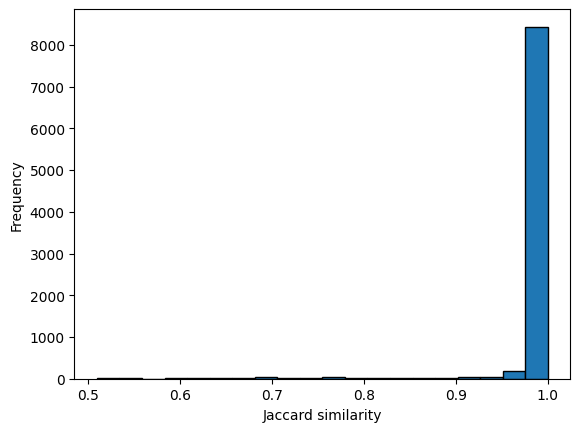

In [39]:
list_sim = merged_rdd.map(lambda x: x[4]).collect()
plt.hist(list_sim, bins=20, edgecolor='black')
plt.xlabel("Jaccard similarity")
plt.ylabel("Frequency")

## Scalability with datasize visualization

In [69]:
def visualise_scalability():
    '''
    Visualizes time of execution for different DATA_SIZES
    '''
    time_res = []

    for data_size in DATA_SIZES:
        start = time.time()

        amazon_bigger = load_data(create_small_csv(data_size))
        signatures_calculated_bigger = (amazon_bigger
                                    .map(lambda p: (p[0], minhash_signature(p[1], 80)))
                                    .cache())
        lsh_matrix_bigger = (signatures_calculated_bigger
                        .flatMap(lambda x: (calculate_lsh(x, b, r)))
                        .cache())
        candidate_pairs_bigger = (lsh_matrix_bigger
                              .map(lambda x: (x[0], [x[1]]))
                              .reduceByKey(lambda a, b: a+b)
                              .filter(lambda r: len(set(r[1]))> 1))
        temp_dict_signatures = signatures_calculated_bigger.collectAsMap()
        amazon_bigger_dict = amazon_bigger.collectAsMap()
        similarity_calculated_bigger = (candidate_pairs_bigger
                                    .flatMap(lambda x: similarity_of_candidates(x, temp_dict_signatures))
                                    .distinct())
        merged_rdd = (similarity_calculated_bigger
                  .filter(lambda x: x[2] > SIMILARITY_THRESHOLD)
                  .map(lambda x: (x[0], amazon_bigger_dict[x[0]],
                                  x[1], amazon_bigger_dict[x[1]],
                                  x[2])))
        merged_rdd.collect()

        time_res.append(time.time() - start)

        print('Finished for datasize: ', data_size)


    plt.figure(figsize=(8, 5))
    plt.plot(DATA_SIZES, time_res, marker='o', linestyle='-', color='blue')
    plt.title("Time vs. data size")
    plt.xlabel("Number of rows")
    plt.ylabel("Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

small_books500.csv - Read 501 lines, successfully parsed 500 lines, failed to parse 0 lines
Finished for datasize:  500
small_books1000.csv - Read 1001 lines, successfully parsed 1000 lines, failed to parse 0 lines
Finished for datasize:  1000
small_books3000.csv - Read 3001 lines, successfully parsed 3000 lines, failed to parse 0 lines
Finished for datasize:  3000
small_books10000.csv - Read 10001 lines, successfully parsed 10000 lines, failed to parse 0 lines
Finished for datasize:  10000
small_books20000.csv - Read 20001 lines, successfully parsed 20000 lines, failed to parse 0 lines
Finished for datasize:  20000
small_books50000.csv - Read 50001 lines, successfully parsed 50000 lines, failed to parse 0 lines
Finished for datasize:  50000


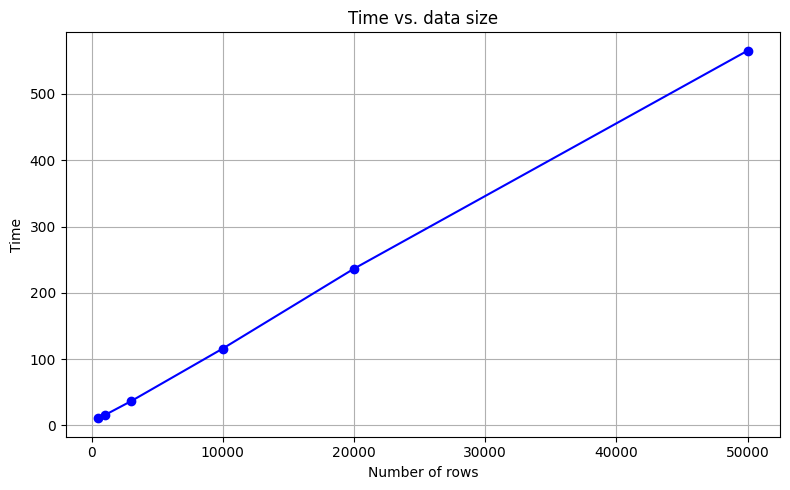

In [70]:
# Takes some time
visualise_scalability()